In [1]:
import os

# Set the environment variable to enable CPU fallback for MPS
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
%env PYTORCH_ENABLE_MPS_FALLBACK=1

env: PYTORCH_ENABLE_MPS_FALLBACK=1


In [2]:
import torch
import torchvision

import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as transforms

from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import TensorDataset, ConcatDataset, random_split, DataLoader, Dataset

import numpy as np

In [3]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    x = torch.ones(1, device=device)
    print (x)
    
elif torch.backends.cuda.is_built():
    device = torch.device("cuda")
    x = torch.ones(1, device=device)
    print (x)
    
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [59]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

mnist_train = torchvision.datasets.MNIST(
    root='./Data',
    train=True,
    download=True,
    transform=transform,
)
mnist_train.targets = torch.ones_like(mnist_train.targets, dtype=torch.float32)

train_loader = torch.utils.data.DataLoader(
    mnist_train, 
    shuffle=True,
    batch_size=64,
)

mnist_test = torchvision.datasets.MNIST(
    root='./Data',
    train=False,
    download=True,
    transform=transform
)
mnist_test.targets = torch.ones_like(mnist_train.targets, dtype=torch.float32)

test_loader = torch.utils.data.DataLoader(
    mnist_test,
    shuffle=True,
    batch_size=64,
)

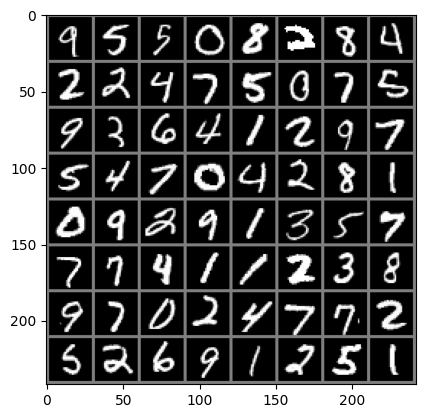

(None,
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))

In [5]:
# Let's show some of the training images, for fun.
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images)), labels

In [6]:
images.shape

torch.Size([64, 1, 28, 28])

Define a simple MLP with 2 linear layers and ReLU. This model currently only produces random noise images with a single normally distributed random input. We produce an output vector of 784 and then convert it to a tensor by putting multiples of 28 numbers as the rows of the matrix

In [7]:
class Generator(nn.Module): 
    def __init__(self):
        super().__init__()
        
        self.linear1 = nn.Linear(1, 256)
        self.relu1 = nn.ReLU()
        
        self.linear2 = nn.Linear(256, 784)
        self.relu2 = nn.ReLU()
    
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu1(x)
        
        x = self.linear2(x)
        x = self.relu2(x)
        
        '''# Need to convert the output vector x to a matrix
        g_out_mat = torch.zeros(1, 28, 28)

        m = 0
        n = 0

        for i in range(len(x)):
            if i % 28 == 0 and i != 0:
                m += 1
                n = 0
                #print(i, m)

            g_out_mat[0, m, n] = x[i]

            n += 1  '''
        
        # Reshape the output to a 28x28 matrix
        x = x.view(-1, 28, 28)
        
        return x
    
generator = Generator()

In [10]:
mu, sigma = 0, 1 # mean and standard deviation
g_in = torch.tensor(np.random.normal(mu, sigma, 1), dtype=torch.float32)
g_in

tensor([-0.2161])

In [11]:
g_out = generator(g_in)

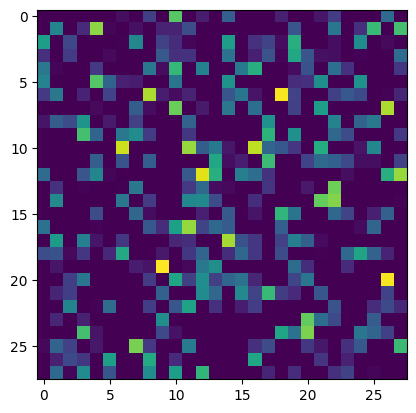

(None, tensor([0.]))

In [12]:
imshow(g_out.detach().cpu()), torch.Tensor([0])

In [13]:
# Maybe we can perform a check on the above noise output image and check if it is indeed just noise? Would
# be nice for my blog post

### Lets add 50% noise samples to the dataset, we will add 60k to train set and 10k to test
This is optional to run, do not run it right away

In [111]:
# Lets first generate 70k noise numbers from the normal dist
noise_tensor = torch.randn(70000, 1)

# Will pass each of these to the model to give us 70k noisy images
generator.eval()
with torch.no_grad():
    gen_images = generator(noise_tensor)
    gen_images = gen_images.unsqueeze(1)

gen_labels = [0] * 70000

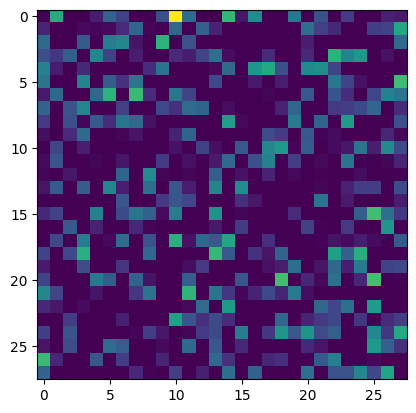

(None, 0)

In [112]:
imshow(gen_images[0].detach()), gen_labels[0]

In [145]:
# Create a new dataset
gen_dataset = TensorDataset(gen_images, torch.tensor(gen_labels, dtype=torch.long))

train_size = 60000
test_size = 10000
gen_train_dataset, gen_test_dataset = random_split(gen_dataset, [train_size, test_size])

In [157]:
# Create a custom dataset class which allows us to keep the labels as integers to match the MNIST data
class CustomTensorDataset(Dataset):
    """Dataset wrapping tensors and integer labels.

    Arguments:
        tensors (Tensor): contains sample data.
        labels (list of int): contains sample labels.
    """
    def __init__(self, tensors, labels):
        assert tensors.size(0) == len(labels)
        self.tensors = tensors
        self.labels = labels

    def __getitem__(self, index):
        return self.tensors[index], self.labels[index]

    def __len__(self):
        return self.tensors.size(0)
    
gen_dataset = CustomTensorDataset(gen_images, gen_labels)

train_size = 60000
test_size = 10000
gen_train_dataset, gen_test_dataset = random_split(gen_dataset, [train_size, test_size])

In [158]:
comb_train_dataset = ConcatDataset([mnist_train, gen_train_dataset])
comb_test_dataset = ConcatDataset([mnist_test, gen_test_dataset])

# Create DataLoaders for the combined datasets
comb_train_loader = DataLoader(comb_train_dataset, batch_size=64, shuffle=True)
comb_test_loader = DataLoader(comb_test_dataset, batch_size=64, shuffle=False)

In [159]:
gen_train_dataset[0], mnist_train[2]

((tensor([[[0.0000, 0.3926, 0.0000, 0.0000, 0.0000, 0.1253, 0.2350, 0.0000,
            0.0000, 0.5951, 0.6860, 0.0597, 0.0000, 0.1500, 0.3885, 0.0000,
            0.1312, 0.0000, 0.0000, 0.4118, 0.0000, 0.3274, 0.0000, 0.0000,
            0.0454, 0.0000, 0.1889, 0.0997],
           [0.1301, 0.0000, 0.0000, 0.0514, 0.1424, 0.0000, 0.1448, 0.1660,
            0.1700, 0.0000, 0.1141, 0.1750, 0.1883, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000, 0.0000, 0.0000, 0.4691, 0.2541, 0.0000, 0.0000,
            0.1152, 0.0340, 0.0000, 0.1638],
           [0.4296, 0.0000, 0.0145, 0.1946, 0.0825, 0.0000, 0.2198, 0.1694,
            0.0000, 0.5468, 0.0000, 0.2817, 0.0970, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000, 0.0000, 0.2706, 0.1089, 0.0000, 0.0000, 0.0000,
            0.0000, 0.1001, 0.0000, 0.1179],
           [0.3631, 0.0000, 0.1151, 0.0000, 0.2698, 0.0000, 0.1523, 0.0000,
            0.0000, 0.0000, 0.2096, 0.0000, 0.0000, 0.5168, 0.2014, 0.2892,
            0.0692, 0.0000, 0

***

In [14]:
class Discriminator(nn.Module): 
    def __init__(self):
        super().__init__()
        
        self.linear1 = nn.Linear(784, 256)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        
        self.linear2 = nn.Linear(256, 1)
        #self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        # Use sigmoid to ensure output is a probability
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        
        x = self.linear2(x)
        #x = self.relu2(x)
        #x = self.dropout2(x)
        
        x = self.sigmoid(x)
        
        return x

discriminator = Discriminator()
discriminator.to(device)

Discriminator(
  (linear1): Linear(in_features=784, out_features=256, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (linear2): Linear(in_features=256, out_features=1, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (sigmoid): Sigmoid()
)

Lets feed 1 image at a time, either from train dataset or the generated noise image from our Generator model and train the discriminator. I will try implement a manual training loop, to train on batch size one updating after each epoch. We have labels 1 - Data from training set, 0 - Data from G

In [21]:
# Lets add the label to the train loader and test loader data. Basically just switch the labels to be all 1s
# Switch all the labels of the mnist train data to 1, which represent true for being from the train set
#mnist_train.targets = torch.ones_like(mnist_train.targets, dtype=torch.float32)
#mnist_test.targets = torch.ones_like(mnist_train.targets, dtype=torch.float32)
# We run these when we load the original mnist_data such that we do not change labels after adding the noise samples

In [22]:
# Lets make a function which will provide the input to the discriminator model. We will flatten the input input 
# We will put a random split on the training input, it will either come from the generator model or the training data


In [169]:
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(discriminator.parameters(), lr=0.05, weight_decay=0.0005, momentum=0.9)

In [56]:
for epoch in range(5):
    discriminator.train()
    i = 0
    data_iter = iter(train_loader)
    running_loss = 0.0

    '''for i, data in enumerate(train_loader, 0):
        # Here I either choose data from the trainset or the generator
    
        inputs, labels = data'''
    
    # Issue with the labels I have no clue what is happening, lets switch tack and try to just train without the 
    # gen samples
    
    while i < len(mnist_train):
        #if torch.rand(1) > 0.5:
        #    mu, sigma = 0, 1 # mean and standard deviation
        #    g_in = torch.Tensor(np.random.normal(mu, sigma, 1))
        #    inputs, labels = generator(g_in)
        #    if i > 0:
        #        i -= 1 # Reset i position
        #    print("gen sample")
        #    print(labels, labels.shape)
            # Convert labels to torch.Tensor and ensure they have the correct shape
            #labels = torch.Tensor(labels).unsqueeze(0)
        #else:
        inputs, labels = next(data_iter)
        #print('train sample')
        #print(f'label: {labels}')
        #print(f'input shape before flattening: {inputs.shape}')
        
    
        # Flatten the input to a vector
        inputs = torch.flatten(inputs, start_dim=1)
        #print(f'input shape after flattening: {inputs.shape}')
        
        
        inputs, labels = inputs.to(device), labels.to(device)
    
        #labels = labels.to(torch.float32)
        optimizer.zero_grad()
        outputs = discriminator(inputs)
        #print(f'outputs shape: {outputs.shape} | labels shape {labels.shape}')
        #print(f'outputs: {outputs} | labels: {labels}')
        
        # Ensure outputs and labels have the same shape
        labels = labels.unsqueeze(1)
        labels = labels.float()
        #print(f'labels shape after view_as: {labels.shape}')
        
        loss = criterion(outputs, labels)
        #print(loss)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        i += 64
 

    # Move this print statement outside the inner loop
    print(f'Epoch [{epoch + 1}] loss: {running_loss / len(train_loader):.3f}')
    running_loss = 0.0

    discriminator.eval()
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            # Push images to mps gpu
            
            images = torch.flatten(images, start_dim=1)
            labels = labels.unsqueeze(1)
            labels = labels.float()
            
            images, labels = images.to(device), labels.to(device)

            # calculate outputs by running images through the network
            outputs = discriminator(images)
            # the class with the highest energy is what we choose as prediction
            predicted = (outputs > 0.5).float()  # Convert probabilities to binary predictions
            #total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / len(mnist_test)
    print(f'Accuracy of the network on the test images: {test_accuracy:.2f}%')

print('Finished Training')

Epoch [1] loss: 0.000
Accuracy of the network on the test images: 100.00%
Epoch [2] loss: 0.000
Accuracy of the network on the test images: 100.00%
Epoch [3] loss: 0.000
Accuracy of the network on the test images: 100.00%
Epoch [4] loss: 0.000
Accuracy of the network on the test images: 100.00%
Epoch [5] loss: 0.000
Accuracy of the network on the test images: 100.00%
Finished Training


In [57]:
# Interesting so if the tensors have a different shape i.e (64), (64,1)
# The sum equates to the 64*64 why?

In [228]:
# Now lets see what happens if we give the model our random noise image
# Doing this makes the model out put roughly 0.5, showing it assigns roughly equal weight to both classes
# I will now generate a bunch of noise samples and add them to the test train set to see what happens
# The addition of noise will be done in a code block above
noise = generator(torch.Tensor(np.random.normal(mu, sigma, 1)))
noise_test = torch.flatten(noise, start_dim=1)
noise_test = noise_test.to(device)
discriminator.eval()
noise_out = discriminator(noise_test)
noise_out

tensor([[5.5968e-06]], device='mps:0', grad_fn=<SigmoidBackward0>)

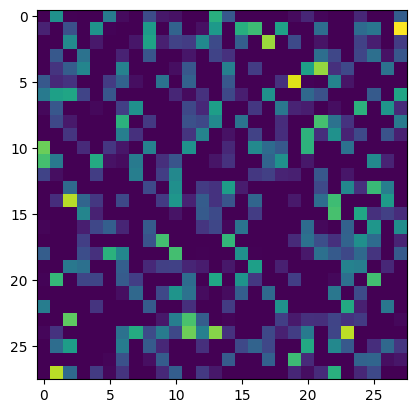

In [229]:
imshow(noise.detach())

In [230]:
noise.shape

torch.Size([1, 28, 28])

In [179]:
test_in = mnist_test[10][0]
test_in = torch.flatten(test_in, start_dim=1)
test_in = test_in.to(device)

discriminator(test_in)

tensor([[1.0000]], device='mps:0', grad_fn=<SigmoidBackward0>)

## Running the discriminator with noise added to the mnist_data
Data originally in mnist has label 1 and the noise has label 0

In [170]:
for epoch in range(5):
    running_loss = 0.0

    for i, data in enumerate(comb_train_loader, 0):
        # Here I either choose data from the trainset or the generator
    
        inputs, labels = data
    
        # Flatten the input to a vector
        inputs = torch.flatten(inputs, start_dim=1)
        
        inputs, labels = inputs.to(device), labels.to(device)
    
        optimizer.zero_grad()
        outputs = discriminator(inputs)
        
        # Ensure outputs and labels have the same shape
        labels = labels.unsqueeze(1)
        labels = labels.float()
        
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
         
    # Move this print statement outside the inner loop
    print(f'Epoch [{epoch + 1}] loss: {running_loss / len(train_loader):.3f}')
    running_loss = 0.0

    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in comb_test_loader:
            images, labels = data
            # Push images to mps gpu
            
            images = torch.flatten(images, start_dim=1)
            labels = labels.unsqueeze(1)
            labels = labels.float()
            
            images, labels = images.to(device), labels.to(device)

            # calculate outputs by running images through the network
            outputs = discriminator(images)
            # the class with the highest energy is what we choose as prediction
            predicted = (outputs > 0.5).float()  # Convert probabilities to binary predictions
            #total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / len(mnist_test + mnist_test)
    print(f'Accuracy of the network on the test images: {test_accuracy:.2f}%')

print('Finished Training')

Epoch [1] loss: 0.000
Accuracy of the network on the test images: 100.00%
Epoch [2] loss: 0.000
Accuracy of the network on the test images: 100.00%
Epoch [3] loss: 0.000
Accuracy of the network on the test images: 100.00%
Epoch [4] loss: 0.000
Accuracy of the network on the test images: 100.00%
Epoch [5] loss: 0.000
Accuracy of the network on the test images: 100.00%
Finished Training


In [ ]:
data_iter = iter(comb_train_loader)
data = next(data_iter)

## So now I have a dataset which contains some random noise samples and the model classifies either if something is random noise or a image from the dataset

In [92]:
class Discriminator(nn.Module): 
    def __init__(self):
        super().__init__()
        
        self.linear1 = nn.Linear(784, 256)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        
        self.linear2 = nn.Linear(256, 1)
        #self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        # Use sigmoid to ensure output is a probability
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        
        x = self.linear2(x)
        #x = self.relu2(x)
        #x = self.dropout2(x)
        
        x = self.sigmoid(x)
        
        return x

discriminator = Discriminator()
discriminator.to(device)

Discriminator(
  (linear1): Linear(in_features=784, out_features=256, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (linear2): Linear(in_features=256, out_features=1, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (sigmoid): Sigmoid()
)

In [93]:
class Generator(nn.Module): 
    def __init__(self):
        super().__init__()
        
        self.linear1 = nn.Linear(1, 256)
        self.relu1 = nn.ReLU()
        
        self.linear2 = nn.Linear(256, 784)
        self.relu2 = nn.ReLU()
    
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu1(x)
        
        x = self.linear2(x)
        x = self.relu2(x)
        
        '''# Need to convert the output vector x to a matrix
        g_out_mat = torch.zeros(1, 28, 28)

        m = 0
        n = 0

        for i in range(len(x)):
            if i % 28 == 0 and i != 0:
                m += 1
                n = 0
                #print(i, m)

            g_out_mat[0, m, n] = x[i]

            n += 1  '''
        
        # Reshape the output to a 28x28 matrix
        x = x.view(-1, 28, 28)
        
        return x
    
generator = Generator()

In [94]:
# Init two optimizers, one for G and one for D
criterion = nn.BCELoss()

static_noise = torch.randn(1)

optimizer_D = torch.optim.SGD(discriminator.parameters(), lr=0.0002, momentum=0.9)
optimizer_G = torch.optim.SGD(generator.parameters(), lr=0.0002, momentum=0.9)

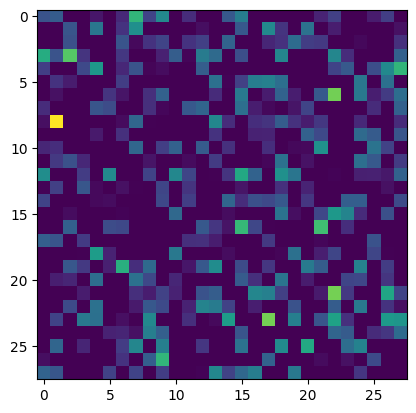

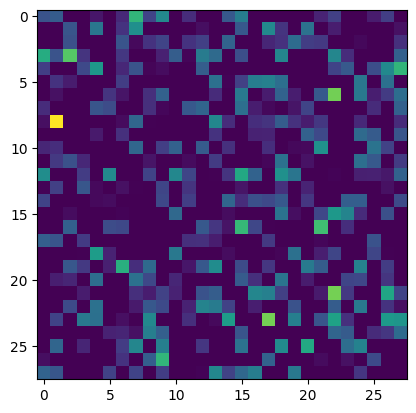

KeyboardInterrupt: 

In [95]:
for epoch in range(5):
    for i, data in enumerate(train_loader):
        inputs, labels = data
        
        # Sample from noise and generate the fake images
        noise_tensor = torch.randn(len(inputs), 1)
        with torch.no_grad():
            gen_images = generator(noise_tensor)
            gen_images = gen_images.unsqueeze(1)
        gen_labels = [0] * len(inputs)
        
        # Concat fake and real images
        combined_images = torch.cat([inputs, gen_images], dim=0)
        combined_labels = torch.cat([labels, torch.tensor(gen_labels)], dim=0)

        # Optional: shuffle the combined batch to prevent the model from learning order
        indices = torch.randperm(combined_images.size(0))
        combined_images = combined_images[indices]
        combined_labels = combined_labels[indices]
        
        combined_images = torch.flatten(combined_images, start_dim=1)
        combined_images, combined_labels = combined_images.to(device), combined_labels.to(device)
        
        combined_labels = combined_labels.unsqueeze(1)
        combined_labels = combined_labels.float()
        
        # First update the D model
        #discriminator.zero_grad()
        optimizer_D.zero_grad()
        d_outputs = discriminator(combined_images)
        
        loss_d = criterion(d_outputs, combined_labels)
        
        loss_d.backward()
        optimizer_D.step()
        
        # Next update the G model, we use the same generated images which we have already created
        #generator.zero_grad()
        optimizer_G.zero_grad()
        
        noise_tensor = torch.randn(len(inputs), 1)
        with torch.no_grad():
            gen_images = generator(noise_tensor)
            gen_images = gen_images.unsqueeze(1)
        gen_labels = [1] * len(inputs)
        
        gen_images = torch.flatten(gen_images, start_dim=1)
        
        # For generator we need to switch the label from fake 0s, to real 1s
        #gen_labels.fill_(0)
        gen_labels = torch.tensor(gen_labels)
        gen_labels = gen_labels.unsqueeze(1)
        gen_labels = gen_labels.float()
        
        gen_images, gen_labels = gen_images.to(device), gen_labels.to(device)
        
        # Note we use the D model, the equation in the paper is max log(D(G(z))) and we already have G(z)
        d_outputs = discriminator(gen_images)
        
        loss_g = criterion(d_outputs, gen_labels)
        
        loss_g.backward()
        optimizer_G.step()
        
    test_out = generator(static_noise)
    imshow(test_out.detach().cpu())
print("Training complete")